In [1]:
# импортирование библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import time
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
)
import random
warnings.filterwarnings("ignore")

# Фиксация случайных состояний для воспроизводимости
random.seed(42)
np.random.seed(42)




In [2]:
# Функция логирования метрик
def log_results(model_name, metrics):
    print(f"\n{model_name} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Функция для PR-кривой
def plot_precision_recall_curve(model, X_test, y_test, model_name, ax=None):
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        if ax is None:
            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve for {model_name}')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'pr_curve_{model_name}.png', dpi=300)
            plt.show()
        else:
            ax.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
        return avg_precision
    except Exception as e:
        print(f"Ошибка при построении PR-кривой для {model_name}: {e}")
        return None

In [3]:
# Загрузка данных
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Выводим имена столбцов для просмотра
print("\nДоступные столбцы в датасете:")
print(df.dtypes, df.shape)

# Проверим наличие пропусков
print("\nПроверка пропущенных значений:")
print(df.isnull().sum())





Доступные столбцы в датасете:
mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points    

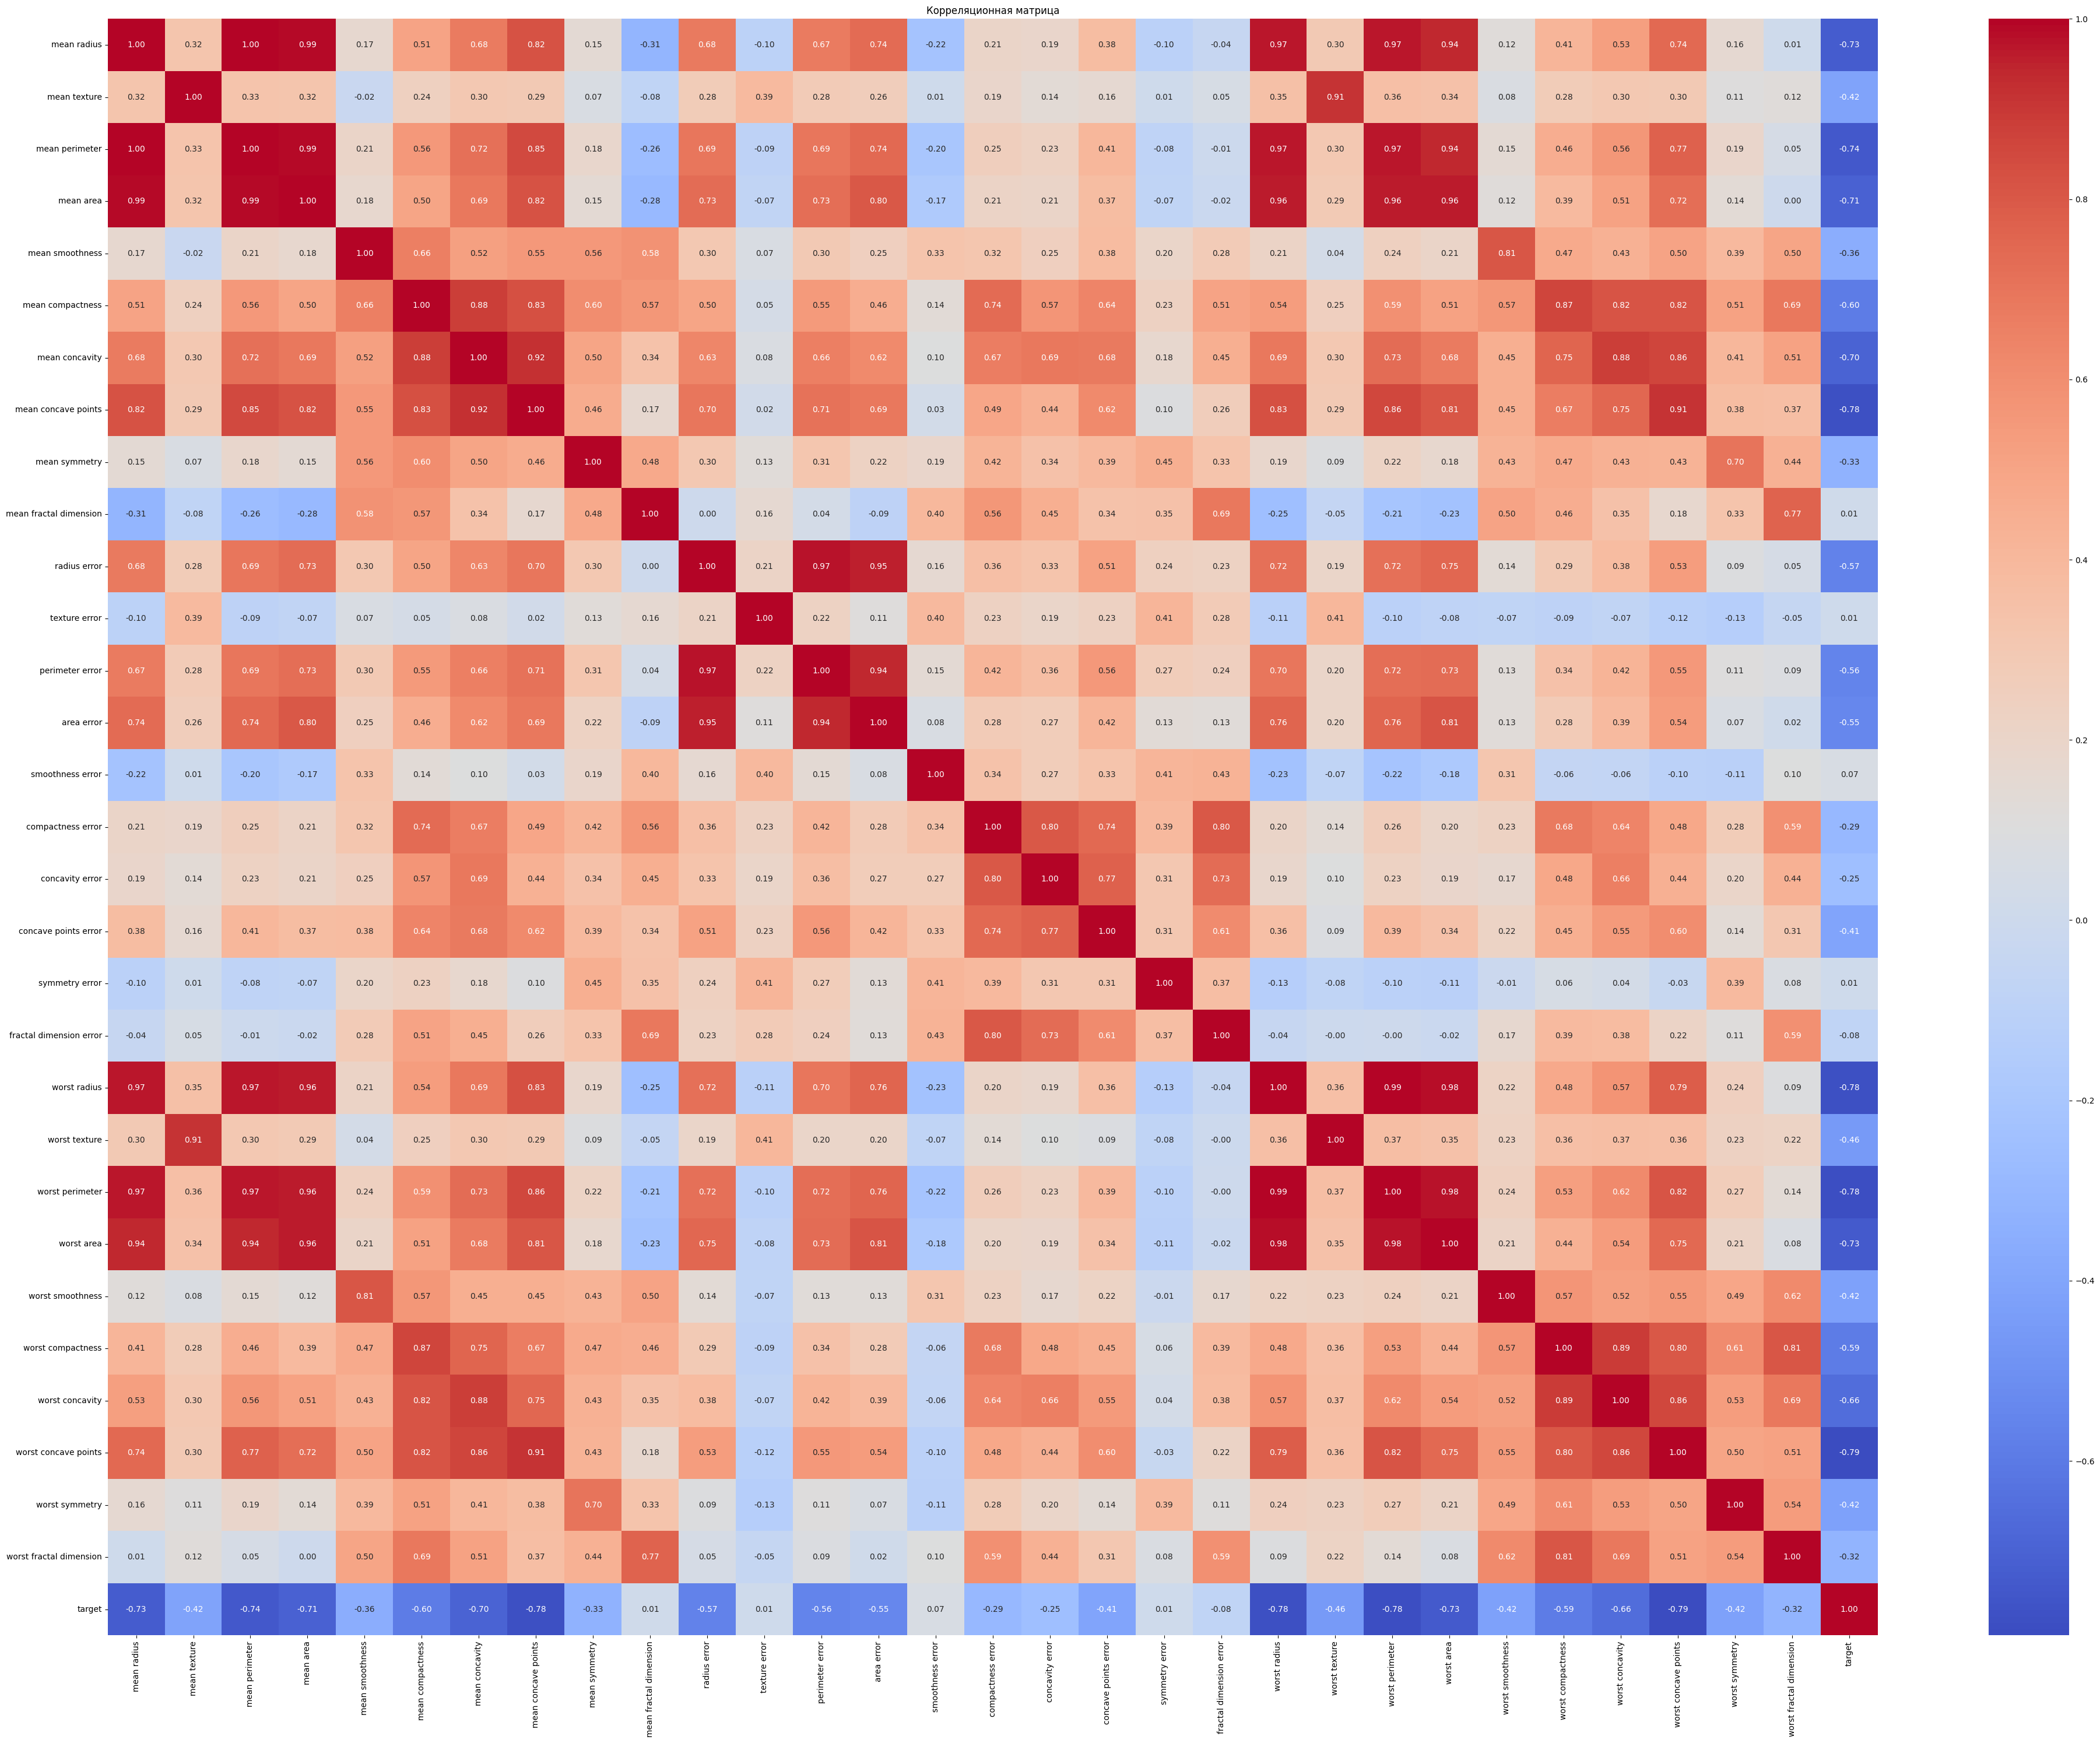

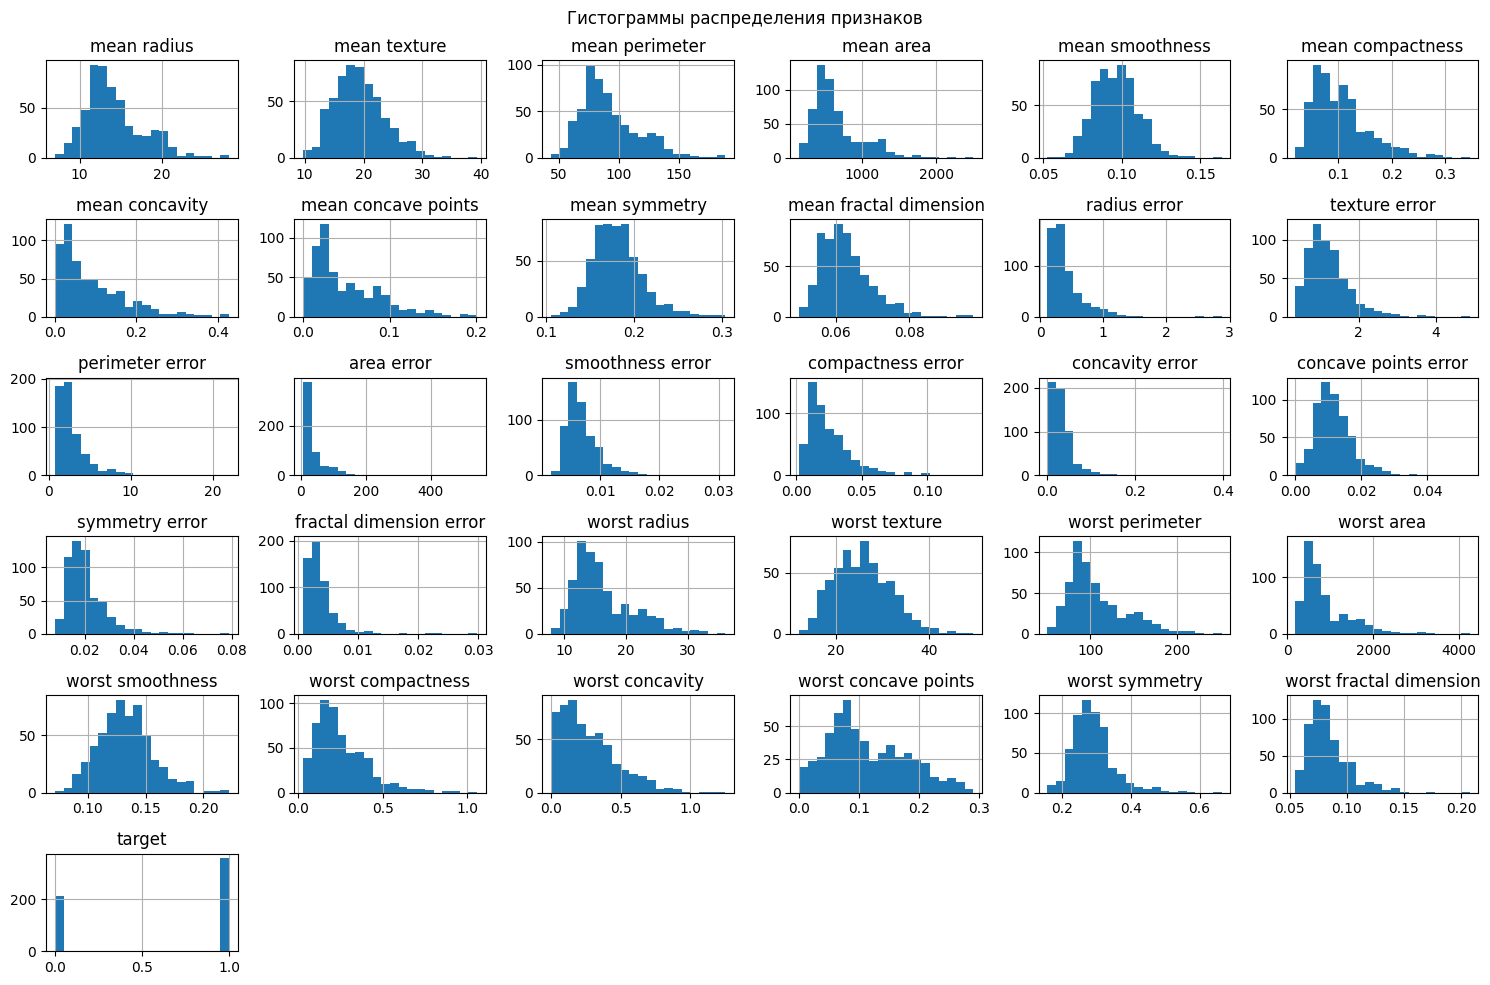

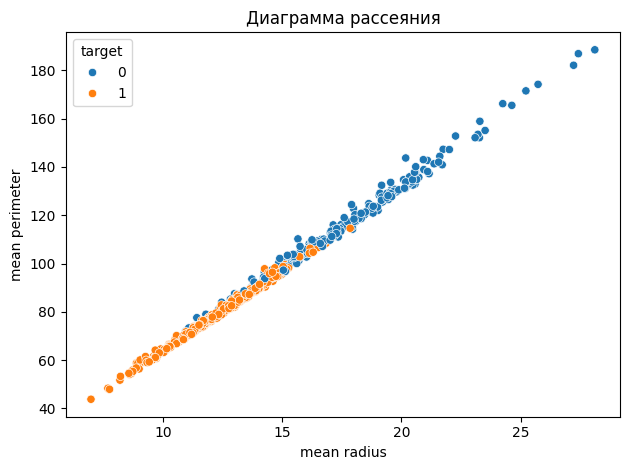

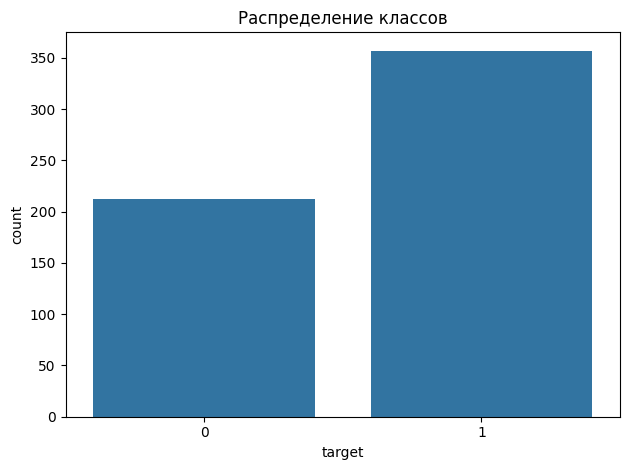

In [4]:
# Визуализация данных

# Корреляционная матрица
plt.figure(figsize=(40, 30))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

# Гистограммы распределения признаков
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Гистограммы распределения признаков')
plt.tight_layout()
plt.savefig('histograms.png', dpi=300)
plt.show()

# Диаграмма рассеяния для двух признаков
sns.scatterplot(x=df['mean radius'], y=df['mean perimeter'], hue=df['target'])
plt.title('Диаграмма рассеяния')
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300)
plt.show()

# Распределение классов
sns.countplot(x=df['target'])
plt.title('Распределение классов')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300)
plt.show()


Удалено 10 признаков из-за высокой корреляции (>0.9):
['mean perimeter', 'mean area', 'mean concave points', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concave points']


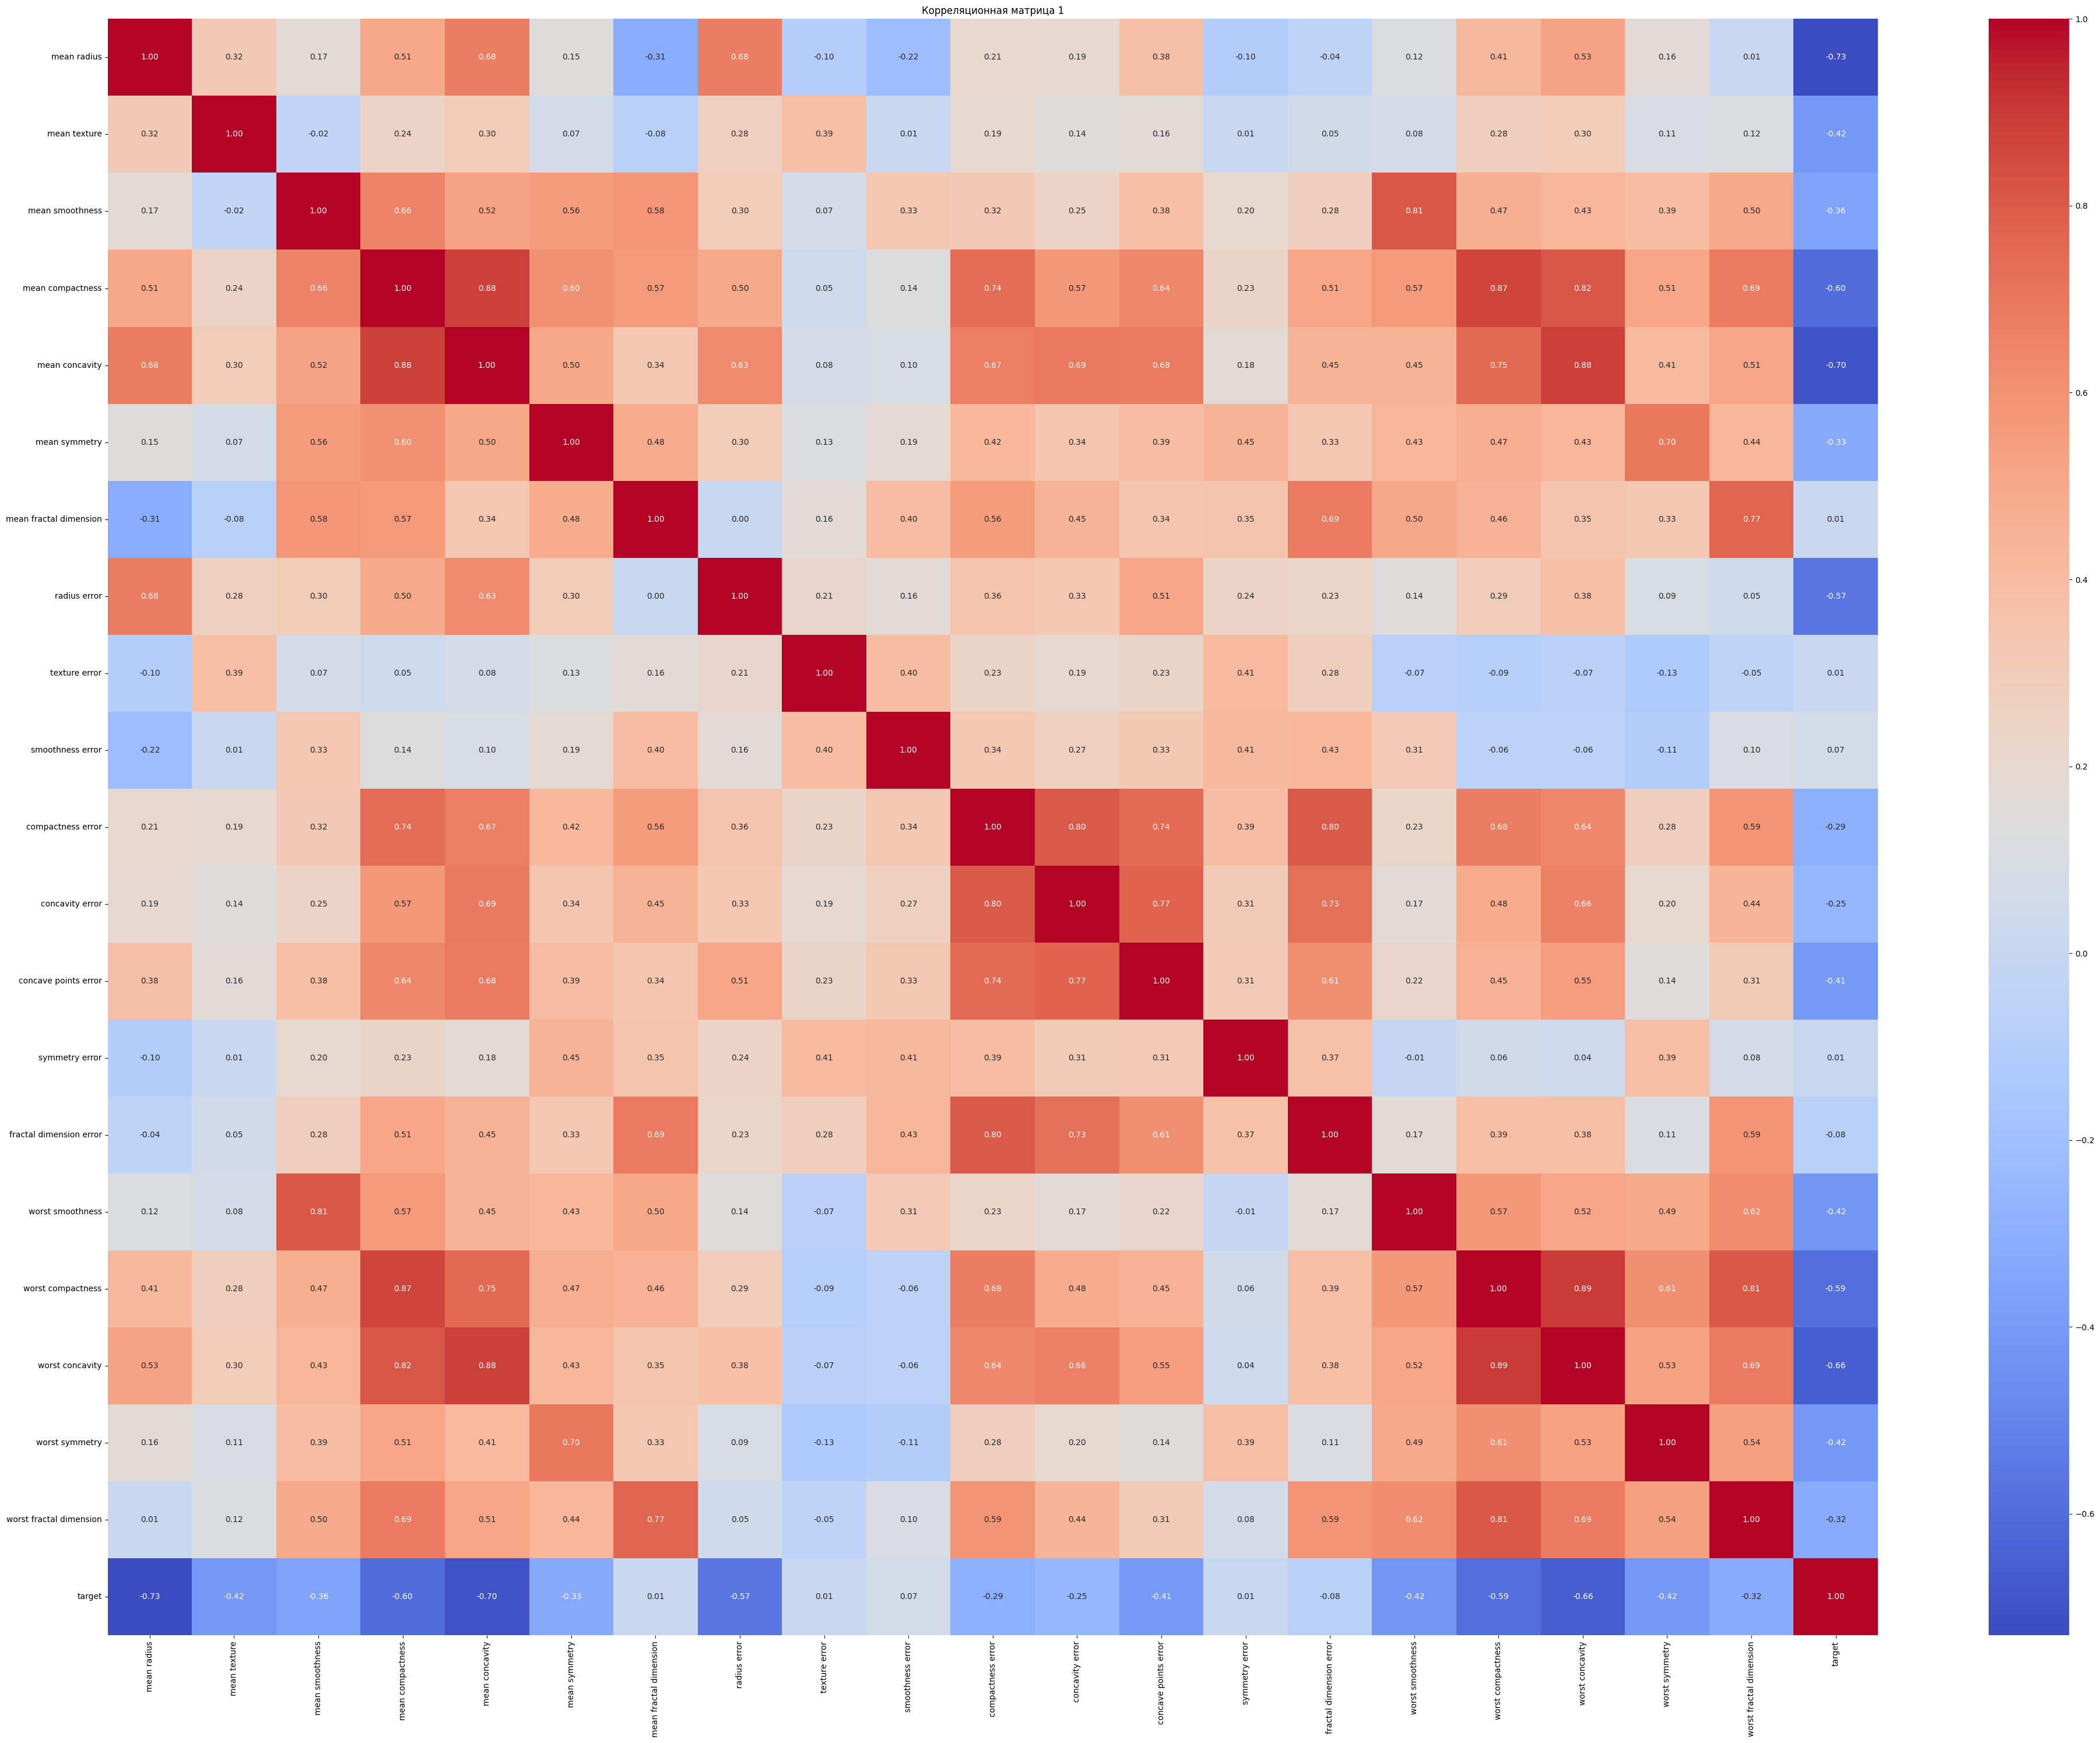

In [5]:
# Функция очистки от высоко коррелированных признаков
def remove_highly_correlated_features(dataframe, threshold=0.90):
    corr_matrix = dataframe.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Найдём признаки с корреляцией > threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"\nУдалено {len(to_drop)} признаков из-за высокой корреляции (>{threshold}):")
    print(to_drop)

    return dataframe.drop(columns=to_drop)

# Применяем к признакам
df_reduced = remove_highly_correlated_features(df.drop('target', axis=1), threshold=0.90)
df_reduced['target'] = df['target']


# Корреляционная матрица после чистки
plt.figure(figsize=(40, 30))
correlation_matrix1 = df_reduced.corr()
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица 1')
plt.tight_layout()
plt.savefig('correlation_matrix1.png', dpi=300)
plt.show()

In [6]:
# Разделение данных на выборки
X = df_reduced.drop('target', axis=1)
y = df_reduced['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [7]:
# Стандартизация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Базовые модели
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

In [9]:
# обучение базовых моделей
print("Обучение базовых моделей с замером времени...")

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    end_time = time.time()

    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted'),
        'Train Time (s)': end_time - start_time
    }
    log_results(name, results[name])
    print(f" Обучение {name} заняло {end_time - start_time:.2f} сек.")

Обучение базовых моделей с замером времени...

Logistic Regression Metrics:
Accuracy: 0.9561
Precision: 0.9581
Recall: 0.9561
F1: 0.9564
Train Time (s): 0.1750
 Обучение Logistic Regression заняло 0.18 сек.

Decision Tree Metrics:
Accuracy: 0.9123
Precision: 0.9119
Recall: 0.9123
F1: 0.9118
Train Time (s): 0.0172
 Обучение Decision Tree заняло 0.02 сек.

KNN Metrics:
Accuracy: 0.9649
Precision: 0.9649
Recall: 0.9649
F1: 0.9649
Train Time (s): 0.0017
 Обучение KNN заняло 0.00 сек.

SVM Metrics:
Accuracy: 0.9737
Precision: 0.9740
Recall: 0.9737
F1: 0.9737
Train Time (s): 0.0226
 Обучение SVM заняло 0.02 сек.

Random Forest Metrics:
Accuracy: 0.9474
Precision: 0.9474
Recall: 0.9474
F1: 0.9471
Train Time (s): 0.2258
 Обучение Random Forest заняло 0.23 сек.

XGBoost Metrics:
Accuracy: 0.9561
Precision: 0.9561
Recall: 0.9561
F1: 0.9560
Train Time (s): 0.7989
 Обучение XGBoost заняло 0.80 сек.


In [10]:
# Стэкинг с начальными гиперпараметрами
base_models_original = [
    ('lr', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('svm', SVC(probability=True, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]
meta_model_original = DecisionTreeClassifier(random_state=42)
stacking_model_original = StackingClassifier(
    estimators=base_models_original,
    final_estimator=meta_model_original,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)
start_time = time.time()
stacking_model_original.fit(X_train_scaled, y_train)
end_time = time.time()
y_pred_stacking_original = stacking_model_original.predict(X_test_scaled)

results['Stacking Original'] = {
    'Accuracy': accuracy_score(y_test, y_pred_stacking_original),
    'Precision': precision_score(y_test, y_pred_stacking_original, average='weighted'),
    'Recall': recall_score(y_test, y_pred_stacking_original, average='weighted'),
    'F1': f1_score(y_test, y_pred_stacking_original, average='weighted'),
    'Train Time (s)': end_time - start_time
}
log_results("Stacking Original", results['Stacking Original'])
print(f" Обучение Stacking Original заняло {end_time - start_time:.2f} сек.")


Stacking Original Metrics:
Accuracy: 0.9737
Precision: 0.9740
Recall: 0.9737
F1: 0.9737
Train Time (s): 2.7226
 Обучение Stacking Original заняло 2.72 сек.


In [11]:
# Улучшенный стэкинг с подобранными гиперпараметрами
base_models_improved = [
    ('lr', LogisticRegression(C=1.0, solver='liblinear', class_weight='balanced', random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='distance')),
    ('svm', SVC(probability=True, kernel='rbf', C=1.5, class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=10, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=2, n_estimators=150, max_depth=4, learning_rate=0.1, random_state=42))
]

meta_model_improved =  SVC(probability=True, kernel='rbf', C=1.5, class_weight='balanced', random_state=42)
stacking_model_improved = StackingClassifier(
    estimators=base_models_improved,
    final_estimator=meta_model_improved,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    passthrough=True,
    n_jobs=-1
)
start_time = time.time()
stacking_model_improved.fit(X_train_scaled, y_train)
end_time = time.time()
y_pred_stacking_improved = stacking_model_improved.predict(X_test_scaled)

results['Stacking Improved'] = {
    'Accuracy': accuracy_score(y_test, y_pred_stacking_improved),
    'Precision': precision_score(y_test, y_pred_stacking_improved, average='weighted'),
    'Recall': recall_score(y_test, y_pred_stacking_improved, average='weighted'),
    'F1': f1_score(y_test, y_pred_stacking_improved, average='weighted'),
    'Train Time (s)': end_time - start_time
}
log_results("Stacking Improved", results['Stacking Improved'])
print(f" Обучение Stacking Improved заняло {end_time - start_time:.2f} сек.")


Создание улучшенного стекинга...

Stacking Improved Metrics:
Accuracy: 0.9912
Precision: 0.9913
Recall: 0.9912
F1: 0.9912
Train Time (s): 2.3108
 Обучение Stacking Improved заняло 2.31 сек.


In [12]:
# Сравнение результатов
results_df = pd.DataFrame(results).T
print("\nСравнение всех моделей:\n")
print(results_df)


Сравнение всех моделей:

                     Accuracy  Precision    Recall        F1  Train Time (s)
Logistic Regression  0.956140   0.958098  0.956140  0.956430        0.175007
Decision Tree        0.912281   0.911949  0.912281  0.911812        0.017169
KNN                  0.964912   0.964912  0.964912  0.964912        0.001653
SVM                  0.973684   0.973969  0.973684  0.973747        0.022598
Random Forest        0.947368   0.947440  0.947368  0.947087        0.225811
XGBoost              0.956140   0.956073  0.956140  0.956027        0.798894
Stacking Original    0.973684   0.973969  0.973684  0.973747        2.722612
Stacking Improved    0.991228   0.991348  0.991228  0.991205        2.310772


In [13]:
# Дополнительная проверка на предсказания ансамблевых моделей
same_preds = np.array_equal(
    stacking_model_original.predict(X_test_scaled),
    stacking_model_improved.predict(X_test_scaled)
)
print(f"\nИдентичны ли предсказания оригинального и улучшенного стэкинга? {same_preds}")


Идентичны ли предсказания оригинального и улучшенного стекинга? False


In [14]:
# Проверка ROC AUC и PR AUC
prob_orig = stacking_model_original.predict_proba(X_test_scaled)[:, 1]
prob_improved = stacking_model_improved.predict_proba(X_test_scaled)[:, 1]

roc_auc_orig = roc_auc_score(y_test, prob_orig)
roc_auc_improved = roc_auc_score(y_test, prob_improved)

pr_auc_orig = average_precision_score(y_test, prob_orig)
pr_auc_improved = average_precision_score(y_test, prob_improved)

print(f"\nROC AUC Original:  {roc_auc_orig:.4f}")
print(f"ROC AUC Improved:  {roc_auc_improved:.4f}")
print(f"PR AUC Original:   {pr_auc_orig:.4f}")
print(f"PR AUC Improved:   {pr_auc_improved:.4f}")



ROC AUC Original:  0.9742
ROC AUC Improved:  0.9937
PR AUC Original:   0.9761
PR AUC Improved:   0.9958


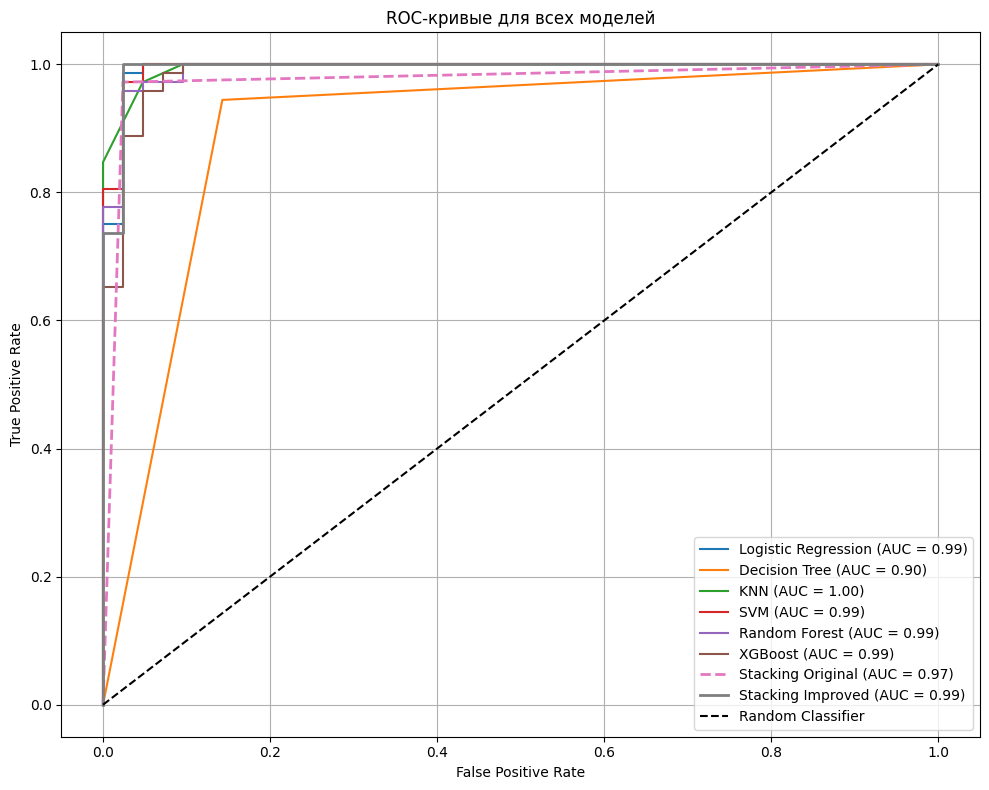

In [15]:
# Построение ROC-кривых
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# ROC-кривая для обычного стэкинга
fpr, tpr, _ = roc_curve(y_test, prob_orig)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Stacking Original (AUC = {roc_auc:.2f})', linestyle='--', linewidth=2)

# ROC-кривая для улучшенного стэкинга
fpr, tpr, _ = roc_curve(y_test, prob_improved)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Stacking Improved (AUC = {roc_auc:.2f})', linestyle='-', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()


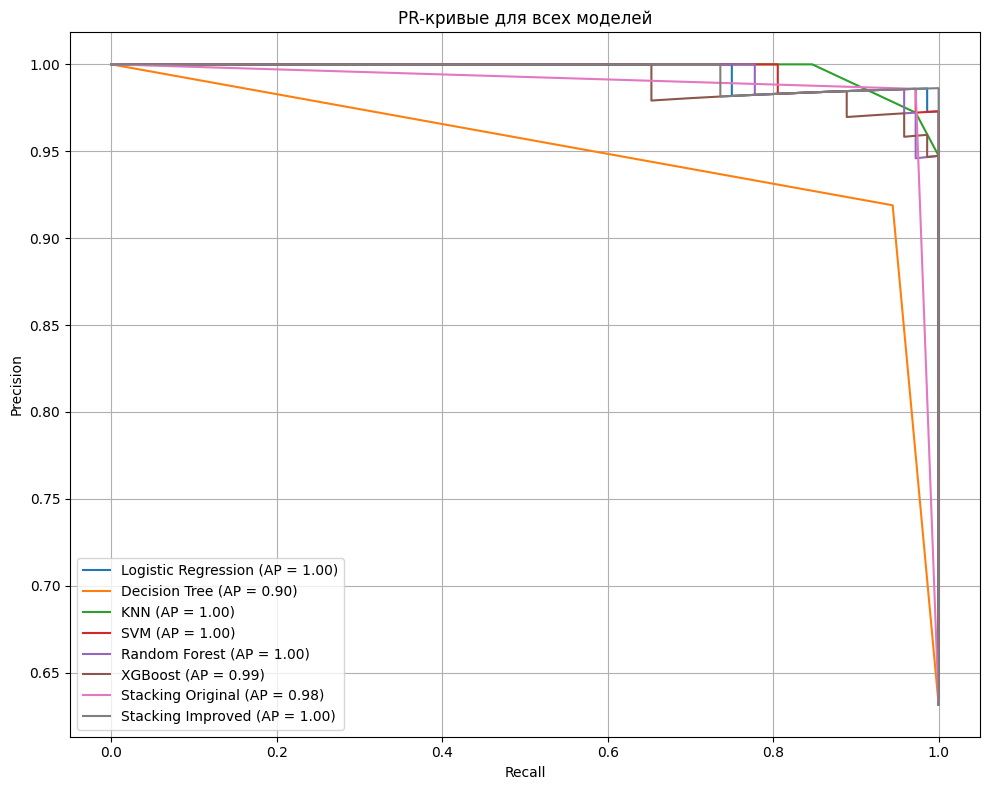

In [16]:
# Построение PR-кривых
fig, ax = plt.subplots(figsize=(10, 8))
for name, model in models.items():
    plot_precision_recall_curve(model, X_test_scaled, y_test, name, ax=ax)

plot_precision_recall_curve(stacking_model_original, X_test_scaled, y_test, 'Stacking Original', ax=ax)
plot_precision_recall_curve(stacking_model_improved, X_test_scaled, y_test, 'Stacking Improved', ax=ax)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('PR-кривые для всех моделей')
ax.legend(loc='best')
ax.grid(True)
plt.tight_layout()
plt.savefig('pr_curves.png', dpi=300)
plt.show()

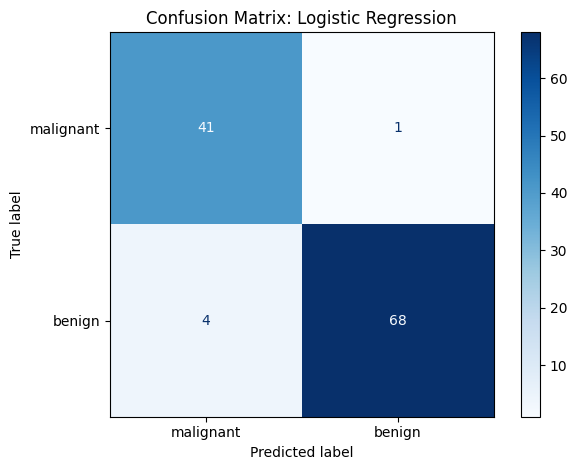

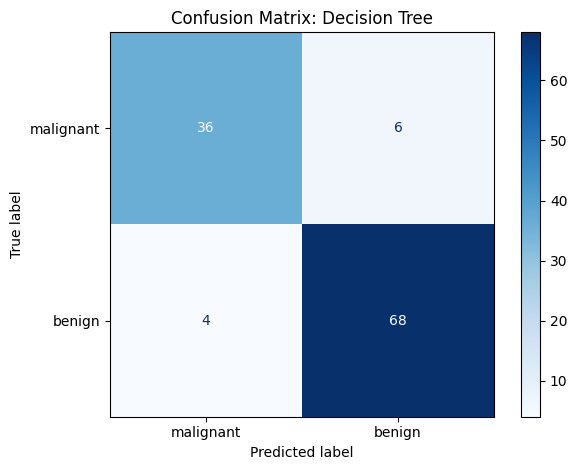

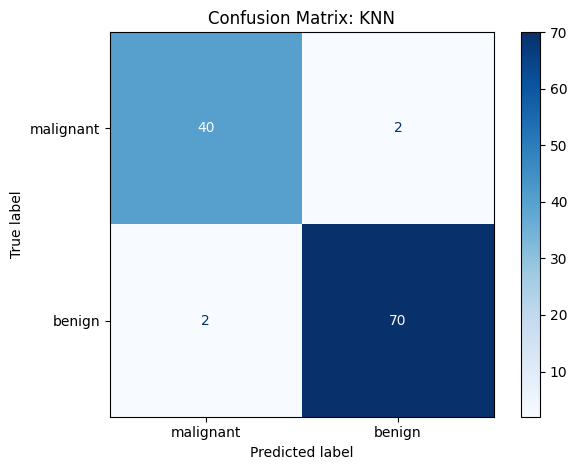

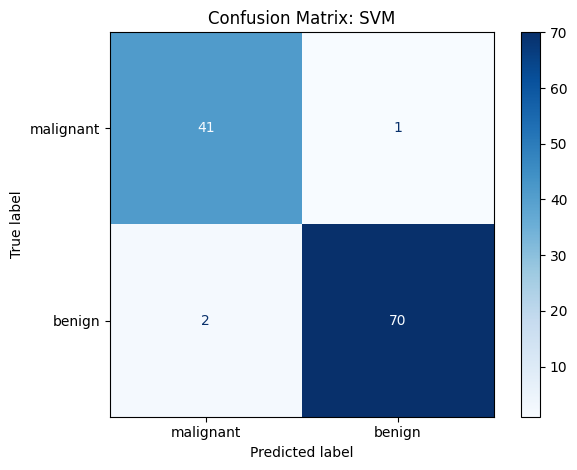

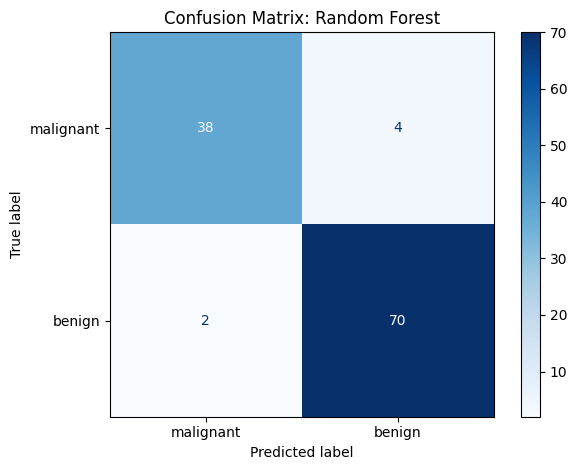

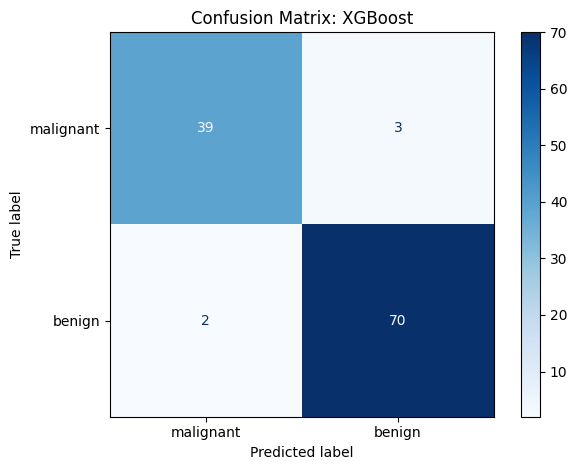

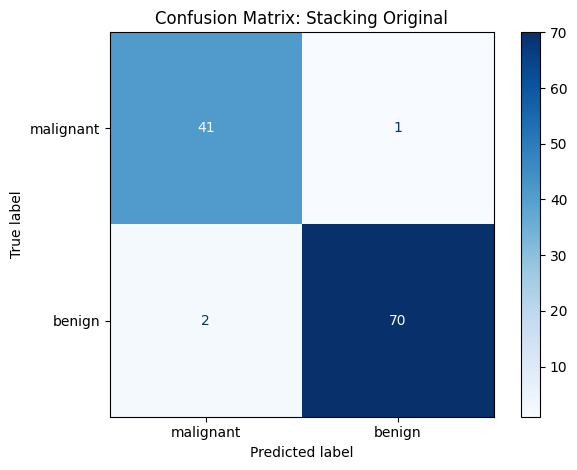

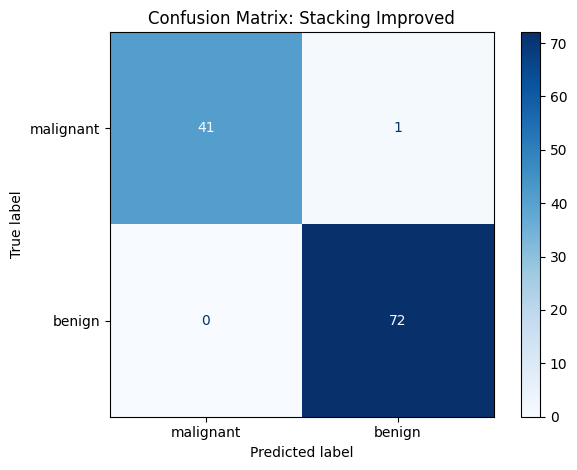

In [17]:
# Матрицы ошибок
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{name}.png', dpi=300)
    plt.show()

# Матрица ошибок для оригинального стэкинга
cm = confusion_matrix(y_test, y_pred_stacking_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Stacking Original')
plt.tight_layout()
plt.savefig('confusion_matrix_stacking_original.png', dpi=300)
plt.show()

# Матрица ошибок для улучшенного стэкинга
cm = confusion_matrix(y_test, y_pred_stacking_improved)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Stacking Improved')
plt.tight_layout()
plt.savefig('confusion_matrix_stacking_improved.png', dpi=300)
plt.show()

In [18]:
# Кросс-валидация по метрике F1
print("\nКросс-валидация моделей (F1-метрика)...")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Для обычного стэкинга
scores = cross_val_score(
    stacking_model_original,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='f1_weighted'
)
print(f"Stacking Original: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Для улучшенного стэкинга
scores = cross_val_score(
    stacking_model_improved,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='f1_weighted'
)
print(f"Stacking Improved: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Кросс-валидация моделей (F1-метрика)...
Logistic Regression: 0.9649 (+/- 0.0254)
Decision Tree: 0.9162 (+/- 0.0577)
KNN: 0.9511 (+/- 0.0672)
SVM: 0.9737 (+/- 0.0326)
Random Forest: 0.9538 (+/- 0.0530)
XGBoost: 0.9581 (+/- 0.0431)
Stacking Original: 0.9428 (+/- 0.0428)
Stacking Improved: 0.9714 (+/- 0.0357)


In [19]:
# Сохранение моделей
print("\nСохранение моделей...")
joblib.dump(stacking_model_original, 'stacking_original_model.pkl')
joblib.dump(stacking_model_improved, 'stacking_improved_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Модели успешно сохранены.")


Сохранение моделей...
Модели успешно сохранены.


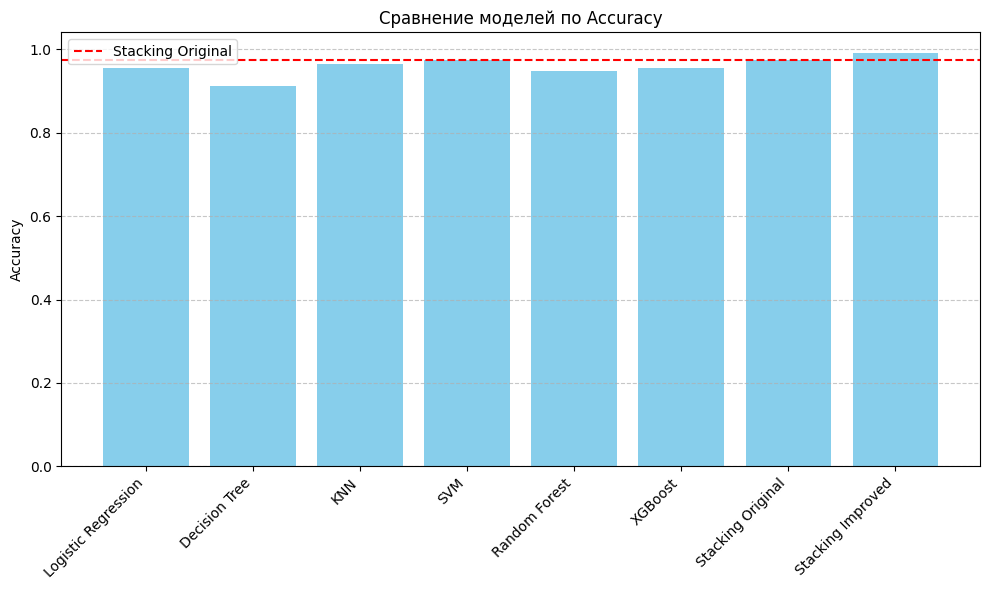

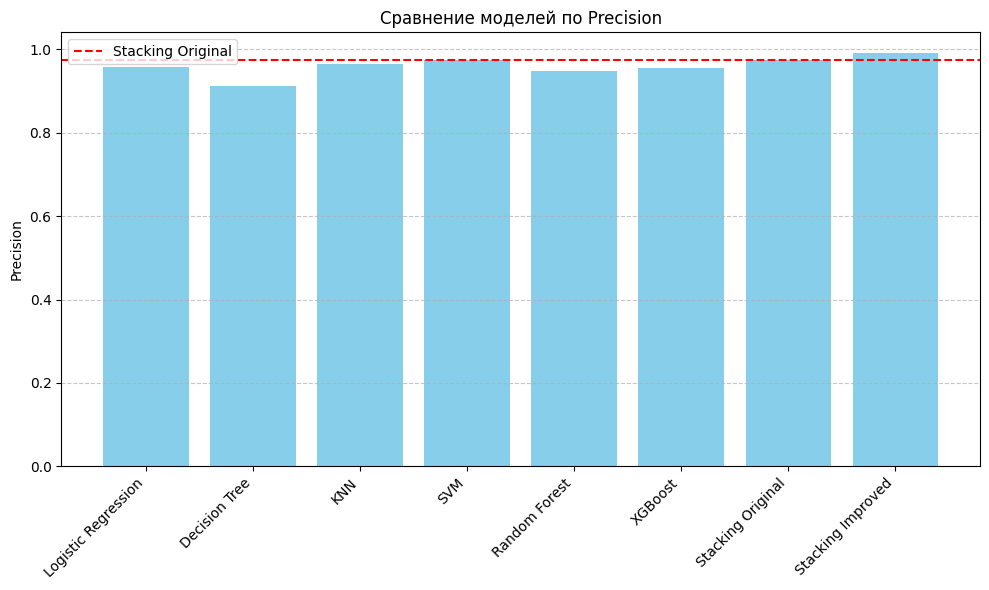

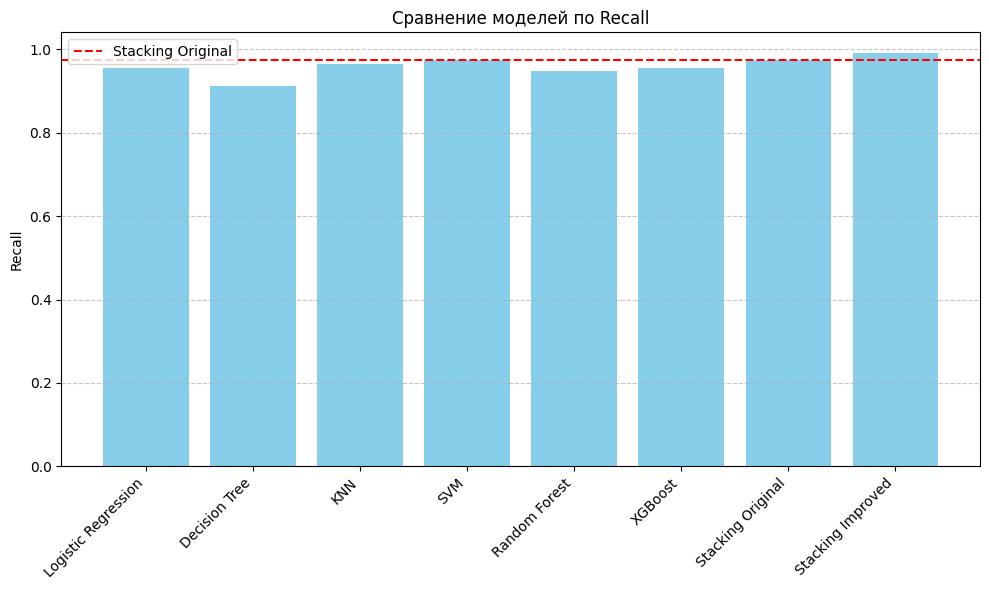

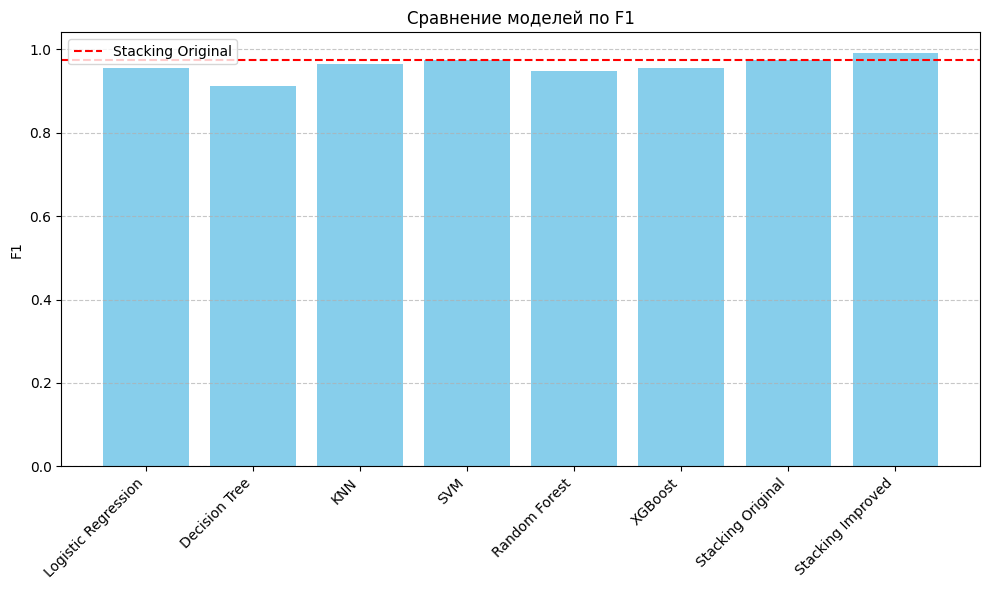

In [20]:
 # Визуализация сравнения метрик

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(results_df.index, results_df[metric], color='skyblue')
    plt.axhline(y=results_df.loc["Stacking Original", metric], color='r', linestyle='--', label='Stacking Original')
    plt.title(f'Сравнение моделей по {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'comparison_{metric}.png', dpi=300)
    plt.show()


In [21]:
# Сохранение результатов в CSV
results_df.to_csv("model_results_comparison.csv", index=True)

In [22]:
# Финальный вывод
print("\n Итоговый вывод:")
print("Улучшенный Stacking по сравнению с оригинальным:")

for metric in metrics:
    improved = results['Stacking Improved'][metric]
    original = results['Stacking Original'][metric]
    diff = improved - original
    if diff > 0:
        status = " Улучшение"
    elif diff < 0:
        status = " Ухудшение"
    else:
        status = " Без изменений"
    print(f"{metric}: {status} на {abs(diff):.4f}")
print("\nАнализ завершён. Все модели обучены, сравнение выполнено, визуализации и модели сохранены.")


 Итоговый вывод:
Улучшенный Stacking по сравнению с оригинальным:
Accuracy:  Улучшение на 0.0175
Precision:  Улучшение на 0.0174
Recall:  Улучшение на 0.0175
F1:  Улучшение на 0.0175

Анализ завершён. Все модели обучены, сравнение выполнено, визуализации и модели сохранены.
